# Interpretable forecasting with N-Beats


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

## Load data


We generate a synthetic dataset to demonstrate the network's capabilities. The data consists of a quadratic trend and a seasonality component.


In [3]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


In [4]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate baseline error


In [5]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

tensor(0.5462)

## Train network


In [6]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 68 steps due to diverging loss.
Learning rate set to 0.0002511886431509581
Restoring states from the checkpoint path at /Users/JanBeitner/Documents/code/pytorch-forecasting/.lr_find_6cdd9176-ee7a-4759-9728-172aaed215f7.ckpt
Restored all states from the checkpoint at /Users/JanBeitner/Documents/code/pytorch-forecasting/.lr_find_6cdd9176-ee7a-4759-9728-172aaed215f7.ckpt


suggested learning rate: 0.0002511886431509581


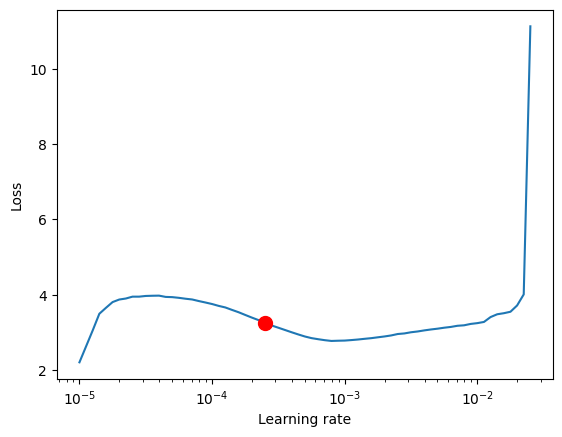

In [7]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model


In [14]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Evaluate Results


In [15]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [16]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to("cpu")
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"))
(actuals - predictions).abs().mean()

tensor(0.1825)

Looking at random samples from the validation set is always a good way to understand if the forecast is reasonable - and it is!


In [17]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True)

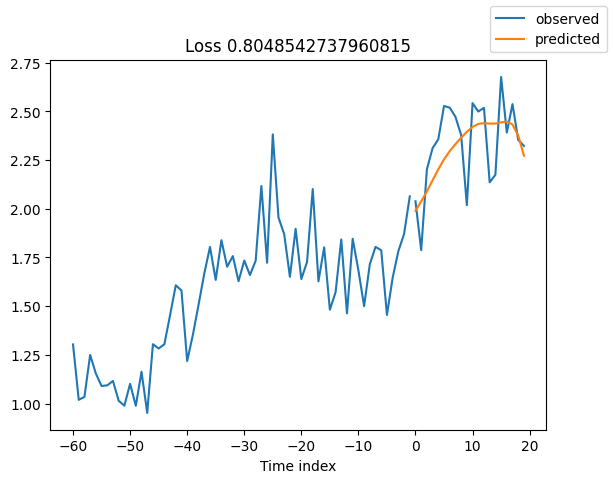

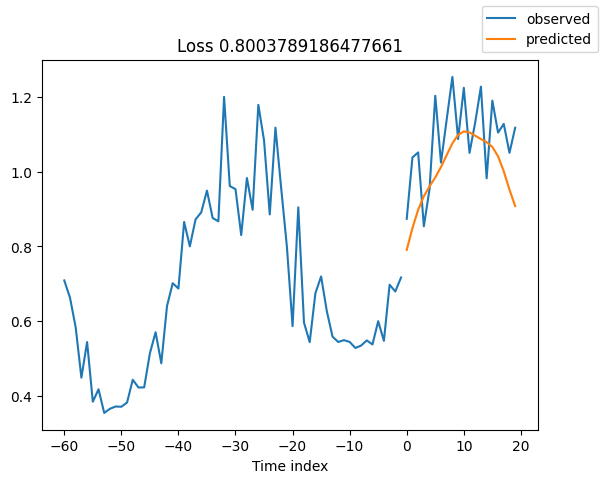

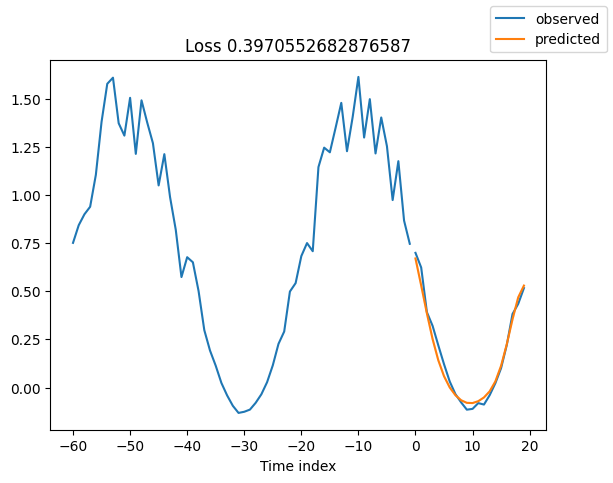

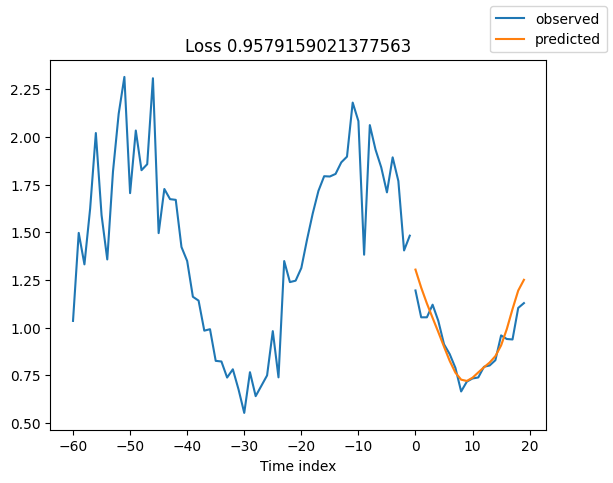

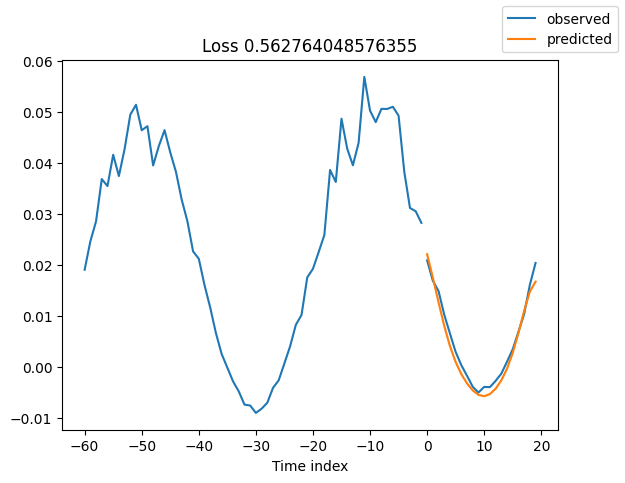

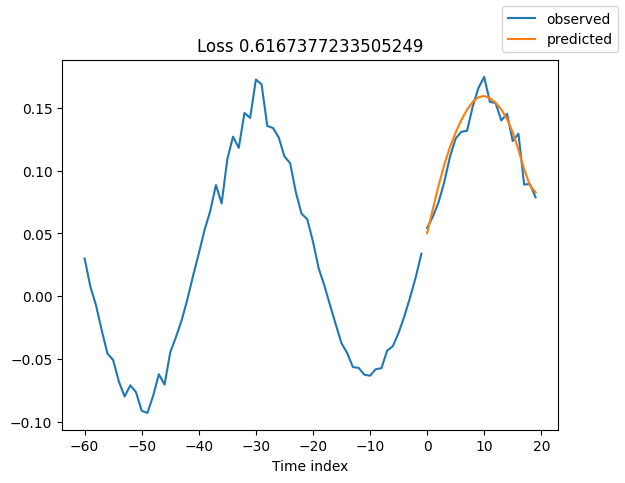

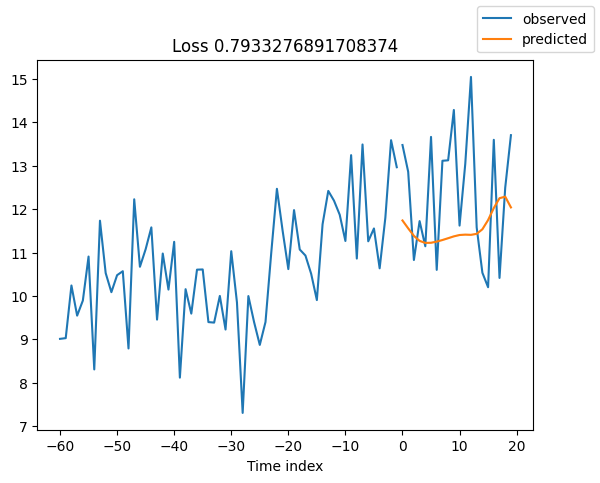

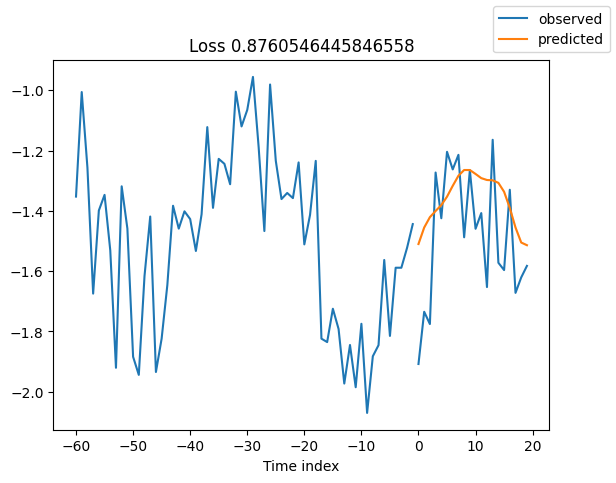

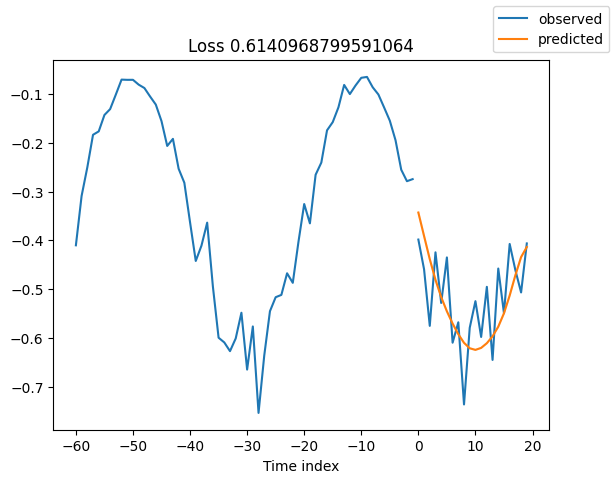

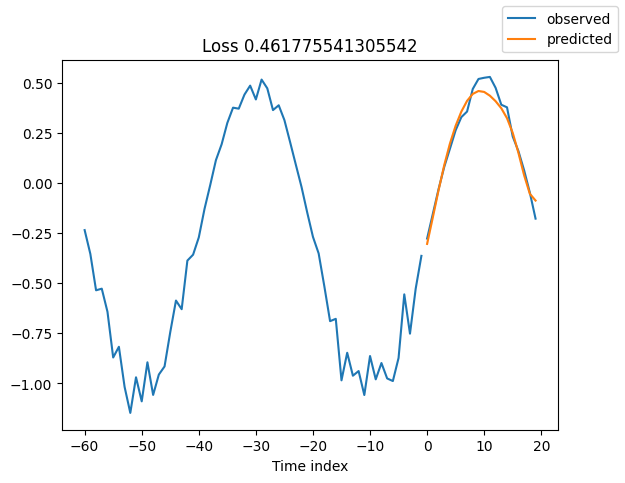

In [18]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

## Interpret model


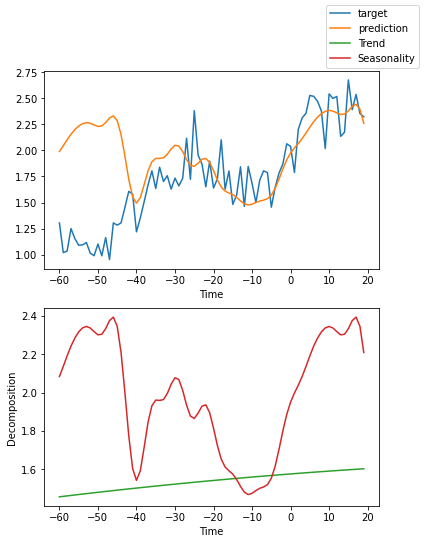

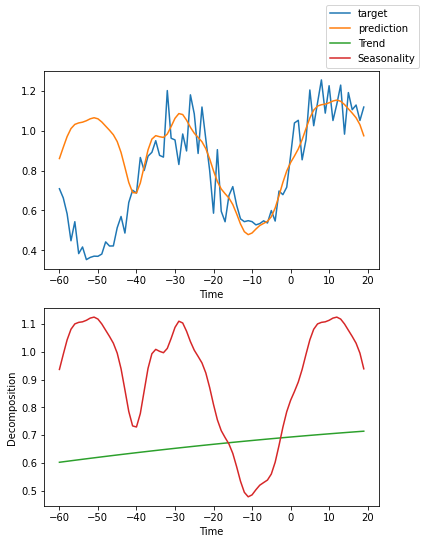

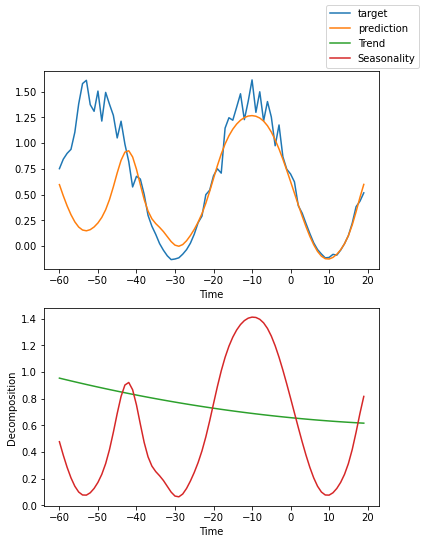

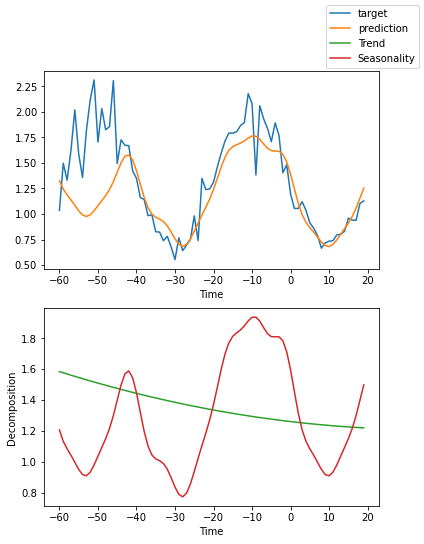

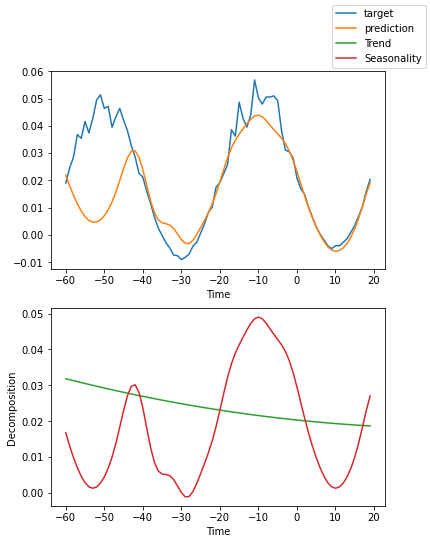

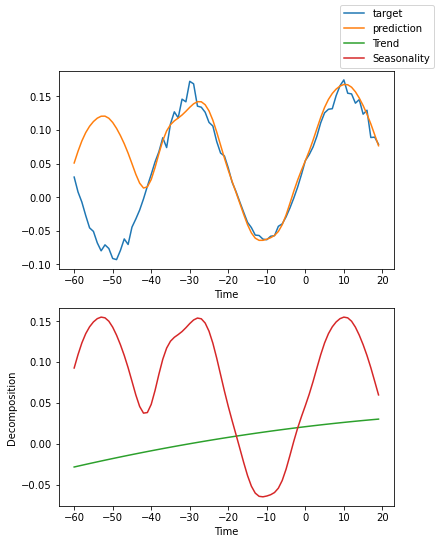

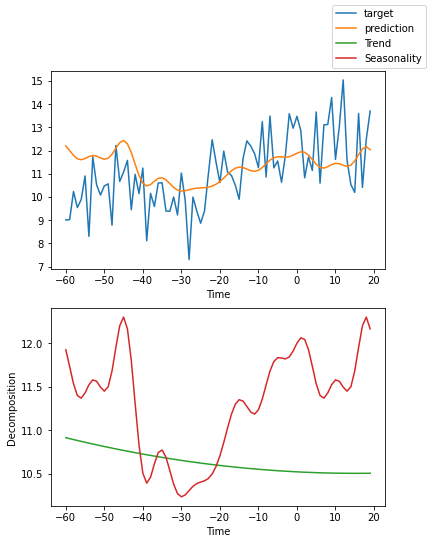

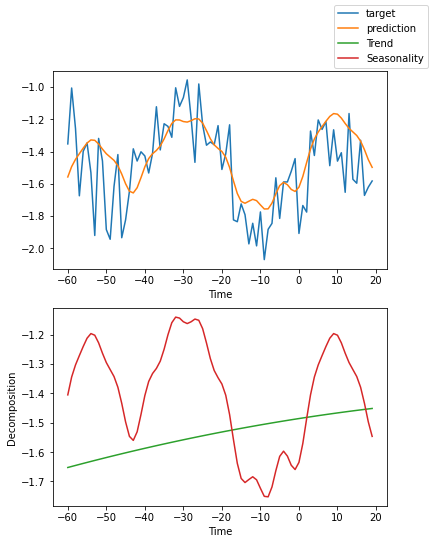

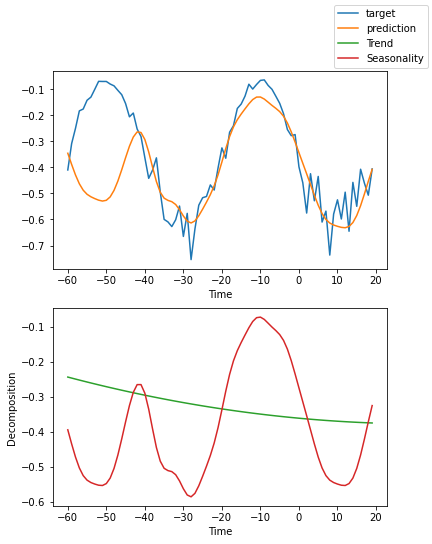

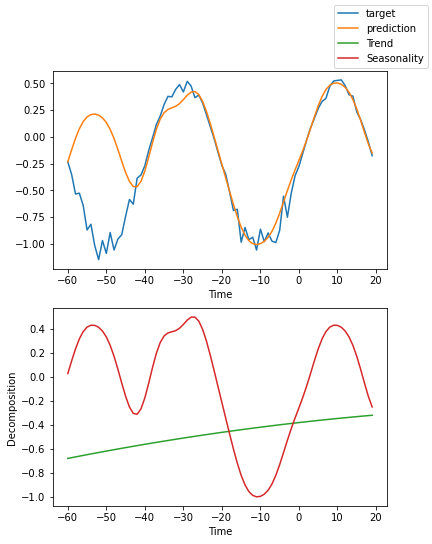

In [13]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)